In [2]:
# oimization ideas:
# 	* find the furthest red pixels up down left right and do the rolling window only there to find if there is a sign
# 	* don't check for every single pixel in shape, rather choose a relevant number of pixels to check and only check that many (
# 		- eg: check every other pixel for a 200 by 200 pixel sign
#       - do a maximum of 1% culling and show at max one at every 10 px on OX and one in every 10 on OY. Balance the values to be 3:2 instead of 6:1


# current best strategy:   
#   * find all red chunks in immage
#   * think of every chunk as a give way sign with:
#       - side starting in the top left highest red pixel and ending in the top right red pixel
#       - and height startign in the lowest red piexel and ending in the perpendicular highest red pixel above
#   * account for rotation and for squishing in the immage
#   * try to get width of the red triangle in pixels and adjust in the funciton
	

In [3]:
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

In [4]:
DATA_DIR = "./my-dataset"
GIVE_WAY_DIR = os.path.join(DATA_DIR, "give-way")

RED_PX = 0
GREEN_PX = 1
BLUE_PX = 2

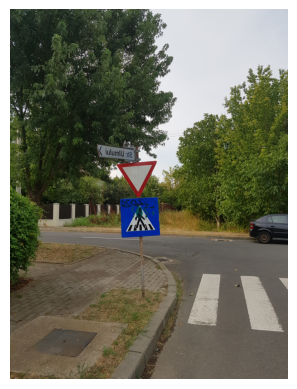

In [5]:
# print a picture

gw_images = []
for img_name in os.listdir(GIVE_WAY_DIR):
    gw_images.append(np.transpose(mpimg.imread(os.path.join(GIVE_WAY_DIR, img_name)), (1, 0, 2)))
    
test_img = gw_images[5]

plt.imshow(test_img)
plt.axis('off')
plt.show()

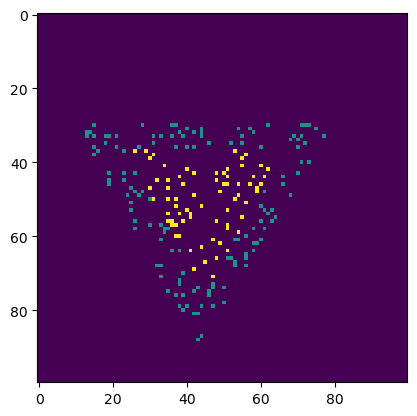

In [6]:
# draw a black and white give way sign of arbitrary size, only draw a portion of the pixels

def between(p_val, p_lower, p_higher):
    return p_val <= p_higher and p_val >= p_lower

def drawSign(p_mat, p_x_start, p_y_start, p_side):
    red_tiangle_height = int(np.sqrt(3 * p_side * p_side /4))
    converging_factor = 2 / np.sqrt(3) # math :)

    shape_area = red_tiangle_height * p_side / 2
    pixels_to_check = 10/100 * shape_area

    px_culling_rate = 1

    if shape_area > pixels_to_check:
        px_culling_rate =  pixels_to_check / shape_area 
        
    red_triangle_width_percent = 0.7
    white_side = int(p_side * red_triangle_width_percent)

    white_x_start = p_x_start + int((p_side - white_side) / 2) 
    white_y_start = p_y_start + int((p_side - white_side) * np.sqrt(3) / 6)
    
    white_triangle_height = int(np.sqrt(3 * white_side * white_side / 4))

    for i in range(p_x_start, p_x_start + red_tiangle_height):
        for j in range(int(p_y_start + ((i - p_x_start)/2) * converging_factor), int(p_y_start + p_side - (i - p_x_start) / 2 * converging_factor)):
            if(np.random.rand() <= px_culling_rate):
                if between(i, 
                    white_x_start - (p_side - white_side) * np.sqrt(3) / 12,
                    white_x_start + white_triangle_height)\
                and between(j, 
                    white_y_start + (p_side - white_side) * np.sqrt(3) / 4 + ((i - white_x_start) / 2) * converging_factor, 
                    white_y_start + white_side - (i - white_x_start) / 2 * converging_factor):
                    
                    p_mat[i][j] = 20
                else:
                    p_mat[i][j] = 10

# matrix = np.zeros((20, 20))
# drawSign(matrix, 1, 6, 10)
# plt.imshow(matrix)

matrix = np.zeros((100, 100))
drawSign(matrix, 30, 10, 70)
plt.imshow(matrix)

# matrix = np.zeros((1000, 1000))
# drawSign(matrix, 10, 400, 600)
# plt.imshow(matrix)

[31 50 31]


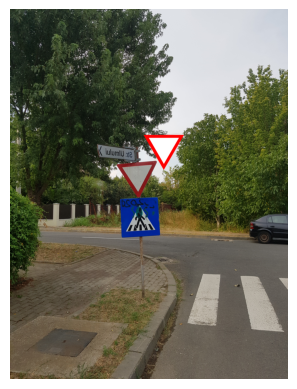

In [7]:
# print a generated give way sign on a immage
def drawRgbSign(p_mat, p_x_start, p_y_start, p_side):
	red_tiangle_height = int(np.sqrt(3 * p_side * p_side /4))
	converging_factor = 2 / np.sqrt(3) # math :)

	shape_area = red_tiangle_height * p_side / 2
	pixels_to_check = shape_area

	px_culling_rate = 1

	if shape_area > pixels_to_check:
		px_culling_rate =  pixels_to_check / shape_area 
		
	red_triangle_width_percent = 0.8
	white_side = int(p_side * red_triangle_width_percent)

	white_x_start = p_x_start + int((p_side - white_side) / 2) 
	white_y_start = p_y_start + int((p_side - white_side) * np.sqrt(3) / 6)
	
	white_triangle_height = int(np.sqrt(3 * white_side * white_side / 4))

	for i in range(p_x_start, p_x_start + red_tiangle_height):
		for j in range(int(p_y_start + ((i - p_x_start)/2) * converging_factor), int(p_y_start + p_side - (i - p_x_start) / 2 * converging_factor)):
			if(np.random.rand() <= px_culling_rate):
				if between(i, 
					white_x_start - (p_side - white_side) * np.sqrt(3) / 12,
					white_x_start + white_triangle_height)\
				and between(j, 
					white_y_start + (p_side - white_side) * np.sqrt(3) / 4 + ((i - white_x_start) / 2) * converging_factor, 
					white_y_start + white_side - (i - white_x_start) / 2 * converging_factor):
					
					for pixel in range(0, 3):
						p_mat[i][j][pixel] = 255
				else:
					p_mat[i][j][RED_PX] = 255
					p_mat[i][j][GREEN_PX] = 0
					p_mat[i][j][BLUE_PX] = 0

np.shape(test_img)
len(test_img[0])
print(test_img[0][0])
img = test_img.copy()

drawRgbSign(img, 1372, 1453, 440)

plt.imshow(img)
plt.axis('off')
plt.show()

[31 50 31]


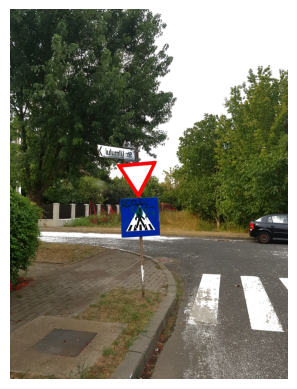

In [11]:
# find treshold values in order to correctly identify white and red

def is_red(p_matrix_px):
    return p_matrix_px[RED_PX] > 2 * p_matrix_px[GREEN_PX] and p_matrix_px[RED_PX] > 2 * p_matrix_px[BLUE_PX]

def is_white(p_matrix_px):
    pixel_RGB_variance = 20
    minimum_red_brightness = 110

    return  p_matrix_px[RED_PX] + pixel_RGB_variance > p_matrix_px[GREEN_PX] and\
            p_matrix_px[RED_PX] - pixel_RGB_variance < p_matrix_px[GREEN_PX] and\
            p_matrix_px[RED_PX] + pixel_RGB_variance > p_matrix_px[BLUE_PX] and\
            p_matrix_px[RED_PX] - pixel_RGB_variance < p_matrix_px[BLUE_PX] and\
            p_matrix_px[RED_PX] > minimum_red_brightness

def check_red(p_img):
    for i in range(0, len(p_img)):
        for j in range(0, len(p_img[0])):
            if is_red(p_img[i][j]):
                p_img[i][j][RED_PX] = 255
                p_img[i][j][GREEN_PX] = 0
                p_img[i][j][BLUE_PX] = 0

            if is_white(p_img[i][j]): 
                p_img[i][j][RED_PX] = 255
                p_img[i][j][GREEN_PX] = 255 
                p_img[i][j][BLUE_PX] = 255 

np.shape(test_img)
len(test_img[0])
print(test_img[0][0])
img = test_img.copy()

check_red(img)

plt.imshow(img)
plt.axis('off')
plt.show()

[31 50 31]


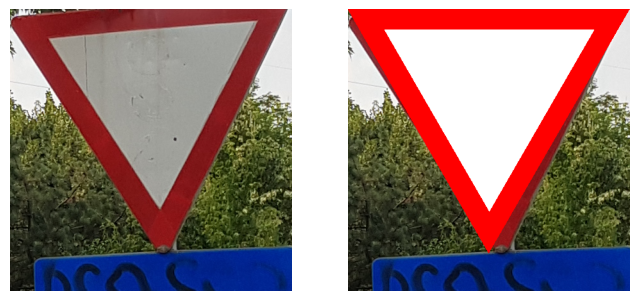

0.11620138391791936


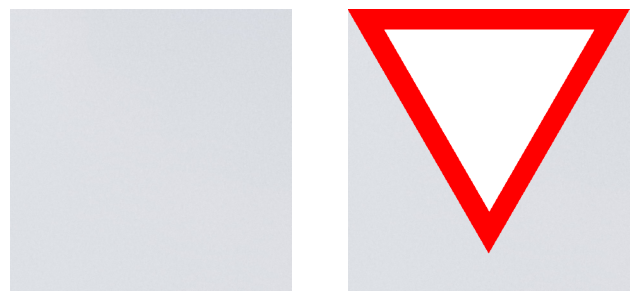

0.44297303746122646


In [9]:
# funciton used to score how close a triangle of side p_side starting at x and y resemples a give way sign

def check_for_sign(p_img, p_x_start, p_y_start, p_side):
	# the difference between the RGB pixels in order for it to be considered white
	color_score = 0

	red_tiangle_height = int(np.sqrt(3 * p_side * p_side /4))
	converging_factor = 2 / np.sqrt(3) # math :)

	shape_area = red_tiangle_height * p_side / 2
	pixels_to_check = 10/100 * shape_area

	px_culling_rate = 1

	if shape_area > pixels_to_check:
		px_culling_rate =  pixels_to_check / shape_area 
		
	red_triangle_width_percent = 0.8
	white_side = int(p_side * red_triangle_width_percent)

	white_x_start = p_x_start + int((p_side - white_side) / 2) 
	white_y_start = p_y_start + int((p_side - white_side) * np.sqrt(3) / 6)
	
	white_triangle_height = int(np.sqrt(3 * white_side * white_side / 4))

	for i in range(p_x_start, p_x_start + red_tiangle_height):
		for j in range(int(p_y_start + ((i - p_x_start)/2) * converging_factor), int(p_y_start + p_side - (i - p_x_start) / 2 * converging_factor)):
			if(np.random.rand() <= px_culling_rate):
				if between(i, 
					white_x_start - (p_side - white_side) * np.sqrt(3) / 12,
					white_x_start + white_triangle_height)\
				and between(j, 
					white_y_start + (p_side - white_side) * np.sqrt(3) / 4 + ((i - white_x_start) / 2) * converging_factor, 
					white_y_start + white_side - (i - white_x_start) / 2 * converging_factor):
					
					if is_white(p_img[i][j]):
						color_score += 1
				else:
					if is_red(p_img[i][j]):
						color_score += 1

	plt.figure(figsize=(8, 4))
	plt.subplot(1, 2, 1)
	plt.axis('off')
	plt.imshow(p_img[p_x_start:p_x_start+p_side, p_y_start:p_y_start+p_side])
	
	ideal_sign = p_img[p_x_start:p_x_start+p_side, p_y_start:p_y_start+p_side].copy() 

	drawRgbSign(ideal_sign, 0, 0, p_side)
	plt.subplot(1, 2, 2)
	plt.axis('off')
	plt.imshow(ideal_sign)

	plt.show()

	return (pixels_to_check - color_score) / pixels_to_check

# def print_selected_shape(img, p_x_start, p_y_start, p_side):
# 	mat_to_print = np.zeros((p_side, p_side, 3))
# 	plt.imshow(mat_to_print)
# 	plt.show()
# 	for i in range(0, p_side):
# 		for j in range(0, p_side):
# 			for px in range(0, 3):
# 				mat_to_print[i][j][px] = img[p_x_start + i][p_y_start + j][px]
	
# 	plt.imshow(mat_to_print)
# 	plt.show()

np.shape(test_img)
len(test_img[0])
print(test_img[0][0])
img = test_img.copy()

# drawRgbSign(img, 0, 1853, 440)
x_val = 1680
y_val = 1160
side = 440

good_score = check_for_sign(test_img, x_val, y_val, side)
print(good_score)

bad_score = check_for_sign(test_img, 0, 1853, 440)
print(bad_score)

In [12]:
# find red chunks and separate them by labling

# def label_red_chunks(p_img, ) 